<h1 STYLE="padding-left:1em;text-align: center;">Projet 05 : Catégorisez automatiquement des questions </h1> 

#  Introduction  
<p STYLE="padding-left:1em;text-align:justify;">Dans ce projet, nous allons proposer une analyse textuelle des questions posées sur le site de 'Stackoverflow' afin de développer un système de suggestion de tag pour le site. Celui-ci prendra la forme d'un algorithme de machine learning qui assignera automatiquement plusieurs tags à une question posée. 
      
<p STYLE="padding-left:1em;text-align:justify;">Ce notebook regroupe les différents travaux menés sur le nettoyage et l'exploration des données.

# Sommaire
<a href="#1" STYLE="padding-left:1em;color:black"><b>Etape 1 : Importation des librairies et des fonctions graphiques</b></a><br>
<a href="#2" STYLE="padding-left:1em;color:black"><b>Etape 2 : Importation des données et sélection des variables pertinentes</b></a><br>
<a href="#3" STYLE="padding-left:1em;color:black"><b>Etape 3 : Nettoyage des données et prétraitement du texte </b></a><br>
<a href="#3.1" STYLE="padding-left:2em;color:black">3.1 Bag of words</a><br>
<a href="#3.2" STYLE="padding-left:2em;color:black">3.2 Pondération des mots : TF–idf</a><br>
<a href="#4" STYLE="padding-left:1em;color:black"><b>Etape 4 : Analyse exploratrice des données</b></a><br>
<a href="#4.1" STYLE="padding-left:2em;color:black">4.1 Analyse univariée</a><br>
<a href="#4.2" STYLE="padding-left:2em;color:black">4.2 Analyse multivariée</a><br>

# <a STYLE="color:black" id="1">Etape 1 : Importation des librairies et des fonctions graphiques 

In [1]:
%matplotlib inline

from ast import literal_eval

import os
from pathlib import Path
import re

from time import time
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

from operator import itemgetter
import collections
from collections import Counter,defaultdict

import pickle
import dill #as pickle

from joblib import parallel_backend, Parallel, delayed , dump , load
from joblib import wrap_non_picklable_objects
from joblib.externals.loky import set_loky_pickler
# set_loky_pickler('pickle')
# set_loky_pickler("dill")

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation as LDA

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bud64\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bud64\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<p STYLE="padding-left:1em;color:blue;"><b>Configuration générale des différents graphiques <font>

In [2]:
plt.rcdefaults()
font_title = {'color': 'blue','weight': 'bold','size': 14}
font_label = {'size': 12}
font_ticks = 12
font_legend = 10
c = []
[c.append(plt.cm.tab20(i)) for i in range(20)]
    
def config_plt(plot = plt, ax = None, title = 'titre', X_name = 'x' , Y_name = 'y' , legend = ''):   
    if plot == plt :
        plot.title(title,fontdict=font_title)
        plot.xlabel(X_name,fontdict=font_label)
        plot.ylabel(Y_name,fontdict=font_label)
        plot.xticks(fontsize =font_ticks)
        plot.yticks(fontsize =font_ticks)
        if legend is not None:
            plot.legend(title = legend , fontsize =font_legend)
    else : 
# Sub-plot
        ax.set_title(title,fontdict=font_title)
        ax.set_xlabel(X_name,fontdict=font_label)
        ax.set_ylabel(Y_name,fontdict=font_label)
        ax.tick_params(axis='x', labelsize=font_ticks)
        ax.tick_params(axis='y', labelsize=font_ticks)
        if legend is not None: 
            ax.legend(title = legend , fontsize =font_legend)

In [3]:
def plot_line(DF, x_cols,cols, categorie= None,Nb_cols=2,marker = '',length=None,width=None,x_lim=None,y_lim =None,title=None,x_name=None,y_name=None,legend=None):
    label = dict() if 'label' not in globals() else globals()['label'] 
    x_cols = [x_cols] if np.array([x_cols]).size == 1 else x_cols 
    cols = [cols]  if np.array([cols]).size == 1 else cols 
    Nb_var =  1 if np.array([cols]).size == 1 else len(cols)
    Nb_row = int(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    length = 4*Nb_row if length is None else length
    fig = plt.figure(figsize=(width,length))    
    for i in range(0,Nb_var):
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1)
        if categorie is None : 
            if len(x_cols)==1:
                axes.plot(DF[x_cols[0]],DF[cols[i]],color = c[0],marker = marker)
            else : 
                axes.plot(DF[x_cols[i]],DF[cols[i]],color = c[0],marker = marker)
        else :
            k=0
            for cat in DF[categorie].unique():
                DF_frac = DF[DF[categorie] == cat]
                if len(x_cols)==1:
                    axes.plot(DF_frac[x_cols[0]],DF_frac[cols[i]],color = c[k],marker = marker,label = cat)
                else : 
                    axes.plot(DF_frac[x_cols[i]],DF_frac[cols[i]],color = c[k],marker = marker, label = cat)
                k+=1
            legend = str(cat if label.get(cat) is None else label.get(cat))
            
        axes.set_xlim(x_lim) if x_lim !=None else None    
        axes.set_ylim(y_lim) if y_lim !=None else None
        
        axes.grid(visible=True,axis='x')
        
        (axes.set_xticks(DF[x_cols[0]]) if axes is not plt else axes.xticks(DF[x_cols[0]])) if DF[x_cols[0]].size<=15 else None 
        
        j = 0 if len(x_cols)==1 else i
        title_plt = '' if title is None else [title if len([cols]) == 1 else title[i]]    
        if x_name is None : 
            x = str(x_cols[j] if label.get(x_cols[j]) is None else label.get(x_cols[j]))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[j]
        if y_name is None : 
            y = str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
            
        config_plt(plot = 'None', ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
        fig.tight_layout()
    plt.show() 

def plot_scatter(DF,x_cols,cols, categorie= None,Nb_cols=2,length=None,width=None,x_lim=None,y_lim =None,title=None,x_name=None,y_name=None,legend=None):
    label = dict() if 'label' not in globals() else globals()['label']
    x_cols = [x_cols] if np.array([x_cols]).size == 1 else x_cols 
    cols = [cols]  if np.array([cols]).size == 1 else cols 
    Nb_var =  1 if np.array([cols]).size == 1 else len(cols)
    Nb_row = round(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    length = 4*Nb_row if length is None else length
    fig = plt.figure(figsize=(width,length))    
    for i in range(0,Nb_var):
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1)
        if categorie is None : 
            if len(x_cols)==1:
                axes.scatter(DF[x_cols[0]],DF[cols[i]],color = c[0],s=1.75)
            else : 
                axes.scatter(DF[x_cols[i]],DF[cols[i]],color = c[0],s=1.75)
        else :
            k=0
            for cat in DF[categorie].unique():
                DF_frac = DF[DF[categorie] == cat]
                if len(x_cols)==1:
                    axes.scatter(DF_frac[x_cols[0]],DF_frac[cols[i]],color = c[k],s=1.75 ,label = cat)
                else : 
                    axes.scatter(DF_frac[x_cols[i]],DF_frac[cols[i]],color = c[k],s=1.75, label = cat)
                k+=1
            legend = str(cat if label.get(cat) is None else label.get(cat))
            
        axes.set_xlim(x_lim) if x_lim !=None else None    
        axes.set_ylim(y_lim) if y_lim !=None else None
        
        j = 0 if len(x_cols)==1 else i
        title_plt = '' if title is None else [title if len([cols]) == 1 else title[i]]    
        if x_name is None : 
            x = str(x_cols[j] if label.get(x_cols[j]) is None else label.get(x_cols[j]))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[j]
        if y_name is None : 
            y = str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
            
        config_plt(plot = 'None', ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
        fig.tight_layout()
    plt.show() 

def plot_bar(DF, x_cols, y_cols = None, Nb_cols=2, inverse_xy=False, height=None, width=None,
             title=None,x_name=None,y_name=None,legend=None):
    
    label = dict() if 'label' not in globals() else globals()['label']
    if DF is None : 
        DF = pd.DataFrame()
        DF['x'] = x_cols
        DF['y'] = y_cols
        x_cols , y_cols = 'x', 'y'
         
    x_cols = [x_cols]  if np.array([x_cols]).size == 1 else x_cols
    y_cols = None if y_cols is None else [y_cols] if np.array([y_cols]).size == 1 else y_cols  
    Nb_var= (1 if len(x_cols)==1 else len(x_cols)) if y_cols is None else len(y_cols) if len(y_cols) > 1 else 1  
    
    Nb_row = round(0.5 + Nb_var/Nb_cols) if Nb_cols> 1 else 1
    width = 4*Nb_cols if width is None else width
    height = 4*Nb_row if height is None else height
    fig = plt.figure(figsize=(width,height)) 

    for i in range(0,Nb_var):
        cols = x_cols[i] if y_cols is None else x_cols[0]
        if (DF[cols].nunique()>16) & (DF[cols].dtypes == object) & (Nb_cols == 1):
            width = min(DF[cols].nunique()/4,30) if inverse_xy==False else width
            height = min(DF[cols].nunique()/4,30) if inverse_xy==True else height
            fig = plt.figure(figsize=(width,height))
        elif (Nb_cols == 1) :
            width = 4*Nb_cols 
            fig = plt.figure(figsize=(width,height))
        elif (DF[cols].nunique()>16) & (DF[cols].dtypes == object) & ( Nb_cols > 1) :
            width = min(DF[cols].nunique()*Nb_cols/4,30)
            fig.set_figwidth(width)
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1) 
        
        if y_cols is None :
            count = DF.groupby(by=DF[cols])[cols].count().sort_values(ascending = False)
            X = count.index.values
            Y = count.values
        else :
            count = DF.groupby(cols).agg({ y_cols[i] : 'sum'}).sort_values(y_cols[i], ascending = False)
            Y = count.iloc[:,0]
            X = count.index.values
            
        if title is None :
            titre = cols if y_cols is None else y_cols[i]
            title_plt = 'Distribution :\n ' + str(titre if label.get(titre) is None else label.get(titre))
        else : 
            title_plt = title if np.array([cols]).size == 1 else title[i]
        if x_name is None :
            x_nom = cols if y_cols is None else cols
            x = str(x_nom if label.get(x_nom) is None else label.get(x_nom))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[i]
        if y_name is None : 
            y_nom = cols if y_cols is None else y_cols[i]
            y = 'Nombre de '+ str(y_nom if label.get(y_nom) is None else label.get(y_nom))  
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
        
        #plot bar
        if len(X)<=20 : 
            axes.bar(X,Y,color=c[0:len(X)]) if inverse_xy==False else axes.barh(X,Y,color=c[0:len(X)])        
            for j in range(0,len(X)):
                axes.bar(X,Y,width=0,color= c[j],label= X[j]) if inverse_xy==False else axes.barh(X,Y,height=0,color=c[j],label= X[j])
        else : 
            axes.bar(X,Y,color=c[0]) if inverse_xy==False else axes.barh(X,Y,color=c[0])
        
        if inverse_xy==False : 
            axes.set_xticks(X) if X.size<=12 else None
            axes.tick_params(axis='x',rotation = 90)
            config_plt(plot = axes, ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
        else :
            axes.set_xticks(Y) if Y.size<=12 else None
            config_plt(plot = axes, ax = axes , title = title_plt , X_name = y, Y_name = x , legend = legend)
    plt.tight_layout()
    plt.show()      
    
def plot_hist(DF, cols, Nb_cols=2 , log ='No',x_lim=None,y_lim =None, title = None , x_name = None, y_name =None , legend = None ):   
    label = dict() if 'label' not in globals() else globals()['label']
    cols = [cols]  if np.array([cols]).size == 1 else cols 
    Nb_var =  1 if np.array([cols]).size == 1 else len(cols)  
    Nb_row = int(Nb_var/Nb_cols + 0.5)
    fig = plt.figure(figsize=(4*Nb_cols,4*Nb_row))               
    for i in range(0,Nb_var): 
        axes = fig.add_subplot(Nb_row,Nb_cols,i+1)
        DF_cols = DF[cols[i]] if x_lim is None else DF[DF[cols[i]]<=max(x_lim)][cols[i]]
        l_bins = 1.0 if (DF_cols.max() - DF_cols.min()) <30 else 2.0   
        bins = np.arange(DF_cols.min(),DF_cols.max()+2*l_bins,l_bins)
        
        DF_cols = np.log(DF_cols) if log!='No' else DF_cols
        bins = np.arange(max(DF_cols.min(),0),DF_cols.max(),np.log(1.1)) if log!='No' else bins
        
        bins = 100 if len(bins) > 100 else bins
        
        axes.set_xlim(x_lim) if x_lim !=None else None    
        axes.set_ylim(y_lim) if y_lim !=None else None
        
        if title is None:    
            title_plt = 'Distribution :\n ' + str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            title_plt = [title if np.array([cols]).size == 1 else title[i]]
        if x_name is None: 
            x = str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            x = x_name if np.array([x_name]).size == 1 else x_name[i]
        x = x + ' (log)' if log != 'No' else x
        if y_name is None: 
            y = 'Nombre de '+ str(cols[i] if label.get(cols[i]) is None else label.get(cols[i]))
        else : 
            y = y_name if np.array([y_name]).size == 1 else x_name[i]
                     
# Tracer des histogrammes
        axes.hist(DF_cols,bins = bins , align = 'left')
        None  if isinstance(bins, int) else axes.set_xticks(bins) if bins.size <= 12 else None
        config_plt(plot = 'None', ax = axes , title = title_plt , X_name = x, Y_name = y , legend = legend)
        fig.tight_layout()
    plt.show()              
    
def plot_boxplot(DF, categorie,cols,Nb_cols=2,x_lim=None,y_lim = None):
    label = dict() if 'label' not in globals() else globals()['label']
    categorie = [categorie] if np.array([cols]).size == 1 else categorie
    Nb_var =  1 if np.array([cols]).size == 1 else len(cols) 
    
    Nb_row = int(Nb_var/Nb_cols + 0.5)
    fig = plt.figure(figsize=(5*Nb_cols,5*Nb_row))

    for i in range(0,Nb_var):
        fig.add_subplot(Nb_row,Nb_cols,i+1)
        axes = sns.boxplot(data=DF, x=categorie[i], y=cols)
        axes.set_xlim(x_lim) if x_lim is not None else None          
        axes.set_ylim(y_lim) if y_lim is not None else  None
        
        title = 'Influence du '+ str(categorie[i] if label.get(categorie[i]) is None else label.get(categorie[i]))+' sur\n '+ str(cols if label.get(cols)is None else label.get(cols))    
        x = str(categorie[i] if label.get(categorie[i]) is None else label.get(categorie[i]))
        y = 'Distribution de ' + str(cols if label.get(cols) is None else label.get(cols))
        config_plt(plot = plt , title = title , X_name = x, Y_name = y , legend = None)
        plt.xticks(rotation = 90)
    fig.tight_layout()
    plt.show()
    
def mat_cor(DF , cols = None ,sort_var = None):
    label = dict() if 'label' not in globals() else globals()['label']
    if cols is None:
        DF_mat_corr = DF.corr()
        fig=plt.figure(figsize=(DF.columns.size/2,DF.columns.size/2))
    else : 
        DF_mat_corr = DF[cols].corr()
        fig=plt.figure(figsize=(np.array(cols).size/2,4))
    
    if sort_var != None:
        DF_cols = DF_mat_corr[sort_var].sort_values(ascending = False).index
        DF_mat_corr = DF_mat_corr.loc[DF_cols,DF_cols]
    
    mask = np.zeros_like(DF_mat_corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(DF_mat_corr, mask = mask,cmap='coolwarm',annot=True, 
                     annot_kws={"size":8 ,'weight':'bold','color':'black'}) 
    
    title = "Coefficients de corrélation de Pearson"
    config_plt(plot = None , ax = ax , title = title , X_name = None , Y_name = None , legend = None)
    plt.show()

# <a STYLE="color:black" id="2">Etape 2 : Importation des données 

In [4]:
from joblib import Memory

location = './cachedir/'
mem = Memory(location,mmap_mode='r+',verbose=0)
if 'data_merge' not in locals():
    mem.clear(warn=False)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Pour récupérer les questions posées sur le site 'https://data.stackexchange.com/stackoverflow/query/new', nous avons effectuer des requètes SQL. Ceci nous a permis de filtrer les données avec les critères suivants :    
<br>&emsp;- un score non nul
<br>&emsp;- un nombre de vue non nul
<br>&emsp;- un nombre de réponse non nul
<br>&emsp;- un nombre de commentaire non nul
<br>&emsp;- un nombre d'ajout dans les favoris non nul</b>

<p STYLE="padding-left:1em ; color:black;text-align: justify;"><b>Ci-dessous un exemple de requète :</b><br><br>TOP 50000 Id, CreationDate, Score, ViewCount, Body, Title, Tags , AnswerCount, CommentCount,FavoriteCount FROM posts 
<br>WHERE Score IS NOT NULL
<br>AND ViewCount IS NOT NULL
<br>AND AnswerCount IS NOT NULL
<br>AND CommentCount IS NOT NULL
<br>AND FavoriteCount IS NOT NULL
<br>ORDER BY CreationDate DESC

In [5]:
path = os.path.abspath('')+'\\Data Brut'
file_data_clean = os.path.abspath('')+'\\Data_Clean'
models = os.path.abspath('')+'\\Modèle'
if os.path.isdir(file_data_clean)==False :
    os.mkdir(file_data_clean)
if os.path.isdir(models)==False :
    os.mkdir(models)

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Fusion des différens fichiers issus du site 'stackoverflow'  

In [6]:
%%time
if os.path.isfile(file_data_clean+'\\data_merge.joblib') :
    data_merge = load(file_data_clean+'\\data_merge.joblib')
else : 
    data_merge = pd.DataFrame()
    for file in os.listdir(path) :
        df = pd.read_csv(path+'\\'+file)
        data_merge = pd.concat([data_merge , df] ).sort_values('Id', ascending=False)
    data_merge.set_index('Id',inplace = True)
    dump(data_merge, file_data_clean+'\\data_merge.joblib',compress = True)

Wall time: 4.18 s


In [7]:
display(data_merge)
data_merge['CreationDate'] = pd.to_datetime(data_merge['CreationDate'])
data_merge.info()

,CreationDate,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
Id,,,,,,,,,
71004368,2022-02-06 05:12:15,0,8,"<p>I have an np.array <code>d1</code> of (3,6), and an np.array <code>a4</code> of (1,6).</p>\n<p>How can I combine the two np.arrays to form an np.array <code>d2</code> of (4,6)?</p>\n<p>My code ...",How to append np.array?,<python><arrays><numpy>,0,0,1
71004204,2022-02-06 04:27:27,-1,31,"<pre class=""lang-py prettyprint-override""><code>def str_to_list(str):\n # Insert your code here\n new = list(str)\n for i in new:\n if i == or (i.isdigit() and int(i) &gt; 5):\n ...",why am I not able to compare a space in string after splitting to a space?,<python><comparison>,2,4,0
71003937,2022-02-06 03:12:44,1,17,<p>When I use developer tool that select element in the page to inspect it. So if I merge them it will select canvas instead. Or Is there anyway to do something like that? Or we have to really dra...,How to merge html element into canvas?,<javascript><html><css><canvas><html5-canvas>,0,0,1
71003909,2022-02-06 03:06:04,0,39,"<p>I'm trying to write code that performs polynomial multiplication using a divide and conquer method. It uses a trick to do only 3 multiplications instead of 4 multiplications, involving splittin...",Polynomial Multiplication using divide and conquer,<python><algorithm><polynomials>,2,3,1
71003701,2022-02-06 02:13:30,0,20,<p>I have to make a program where there is board and an arrow on the first tile. I have to make this arrow go to every tile. My problem is I have no idea how to make it go forward properly. I have...,How do I make a function or code to make the arrow move?,<c>,0,3,0
...,...,...,...,...,...,...,...,...,...
68942086,2021-08-26 16:17:19,0,154,<p>I can connect to our legacy company DOMAIN and query Active Directory. This has been my way to get the membership of groups.</p>\n<p>We've added Office 365 and I cannot find the new groups add...,How to query Azure Active Directory as an end user,<active-directory><azure-active-directory><office365>,1,0,1
68942024,2021-08-26 16:12:38,0,40,"<p>Consider the following pybind11/C++ code:</p>\n<pre class=""lang-cpp prettyprint-override""><code>#include &lt;pybind11/pybind11.h&gt;\n#include &lt;pybind11/stl.h&gt;\n#include &lt;pybind11/stl_...",Automatic argument promotion in pybind11,<python><c++><pybind11>,0,0,1
68941971,2021-08-26 16:08:46,0,41,"<p>I'm working on an app that allows a bit of user-defined CSS. I need to wrap every CSS selector with a parent class, <code>.template-container</code>. Example:</p>\n<pre><code>h2 { \n border: ...",RegEx substitution with JavaScript - add a parent class to every CSS selector in a stylesheet,<javascript><regex>,5,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 71004368 to 68941870
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CreationDate   50000 non-null  datetime64[ns]
 1   Score          50000 non-null  int64         
 2   ViewCount      50000 non-null  int64         
 3   Body           50000 non-null  object        
 4   Title          50000 non-null  object        
 5   Tags           50000 non-null  object        
 6   AnswerCount    50000 non-null  int64         
 7   CommentCount   50000 non-null  int64         
 8   FavoriteCount  50000 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 3.8+ MB


<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Sélection des variables d'intérêt 

In [8]:
DF_words_tags = data_merge[['Title','Body','Tags']].copy()
DF_words_tags

,Title,Body,Tags
Id,,,
71004368,How to append np.array?,"<p>I have an np.array <code>d1</code> of (3,6), and an np.array <code>a4</code> of (1,6).</p>\n<p>How can I combine the two np.arrays to form an np.array <code>d2</code> of (4,6)?</p>\n<p>My code ...",<python><arrays><numpy>
71004204,why am I not able to compare a space in string after splitting to a space?,"<pre class=""lang-py prettyprint-override""><code>def str_to_list(str):\n # Insert your code here\n new = list(str)\n for i in new:\n if i == or (i.isdigit() and int(i) &gt; 5):\n ...",<python><comparison>
71003937,How to merge html element into canvas?,<p>When I use developer tool that select element in the page to inspect it. So if I merge them it will select canvas instead. Or Is there anyway to do something like that? Or we have to really dra...,<javascript><html><css><canvas><html5-canvas>
71003909,Polynomial Multiplication using divide and conquer,"<p>I'm trying to write code that performs polynomial multiplication using a divide and conquer method. It uses a trick to do only 3 multiplications instead of 4 multiplications, involving splittin...",<python><algorithm><polynomials>
71003701,How do I make a function or code to make the arrow move?,<p>I have to make a program where there is board and an arrow on the first tile. I have to make this arrow go to every tile. My problem is I have no idea how to make it go forward properly. I have...,<c>
...,...,...,...
68942086,How to query Azure Active Directory as an end user,<p>I can connect to our legacy company DOMAIN and query Active Directory. This has been my way to get the membership of groups.</p>\n<p>We've added Office 365 and I cannot find the new groups add...,<active-directory><azure-active-directory><office365>
68942024,Automatic argument promotion in pybind11,"<p>Consider the following pybind11/C++ code:</p>\n<pre class=""lang-cpp prettyprint-override""><code>#include &lt;pybind11/pybind11.h&gt;\n#include &lt;pybind11/stl.h&gt;\n#include &lt;pybind11/stl_...",<python><c++><pybind11>
68941971,RegEx substitution with JavaScript - add a parent class to every CSS selector in a stylesheet,"<p>I'm working on an app that allows a bit of user-defined CSS. I need to wrap every CSS selector with a parent class, <code>.template-container</code>. Example:</p>\n<pre><code>h2 { \n border: ...",<javascript><regex>


# <a STYLE="color:black" id="3">Etape 3 : Nettoyage des données et prétraitement du texte 
## <a STYLE="color:black" id="3.1">3.1 Bag of words</a> 

In [9]:
@wrap_non_picklable_objects
def get_wordnet_pos(word):
#Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

@delayed
@wrap_non_picklable_objects
def review_to_words(raw_review, lem = True , Porter=True):
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    
    # 2. Remove non-letters and Convert to lower case, split into individual words
    words = re.findall(r'(?u)\b[a-zA-Z][a-zA-Z+#.]*\b[+#]*', review_text.lower())
    words = [w for w in words if (len(w)>2)|(w[0]=='c')|(w[0]=='r')]

    # 3. Stem or Lem all the words   
    if lem == True : 
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in words]
    else : 
        Stem = PorterStemmer() if Porter == True else EnglishStemmer()
        words = [Stem.stem(word) for word in words]

    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
     
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return " ".join(meaningful_words)  

@delayed
@wrap_non_picklable_objects
def unique_words(raw):
    raw = set(raw.split())
    return (' '.join( raw ))

# Fonction pour calcul parallèle de la boucle for 
def applyParallel(df, func):
    data = Parallel(n_jobs=-1)(func(df.loc[i]) for i in df.index)
    return data

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Création d'une variablecomptant le nombre de tags et une variable combinant les variables <span STYLE="color:gray;" ><i> 'Title' et 'Body'</i></span> qui ont été traité auparavant avec les opérations suivantes :   <br>&emsp;- Suppression des balises HTML
<br>&emsp;- Suppression des caractères qui ne sont pas des lettres (hors '+', '#') et des mots inférieurs à 3 lettres
<br>&emsp;- Conversion des lettres en minuscule
<br>&emsp;- Lemmatisation
<br>&emsp;- Suppressions des 'stopwords'

In [10]:
%%time
if os.path.isfile(file_data_clean+'\\DF_words_tags') :
    DF_words_tags = load(file_data_clean+'\\DF_words_tags')
else :
    a=0
    test = False
    while test == False :
        a+=1
        try :     
            data = applyParallel(DF_words_tags.copy().sample(10).Title, review_to_words)
            test = True
            print(f'Boucle : {a} --> Fin erreur : Could not pickle the task to send it to the workers')
        except :
            print(f'Boucle : {a}')
            test = False   
    DF_words_tags['Title'] = applyParallel(DF_words_tags.Title, review_to_words)
    DF_words_tags['Body'] = applyParallel(DF_words_tags.Body, review_to_words)
    DF_words_tags['Tags'] = DF_words_tags['Tags'].str.replace('><',' ').str.replace('<|>','')
    DF_words_tags['Questions'] = DF_words_tags['Title'] + ' ' + DF_words_tags['Body']
    DF_words_tags['Questions'] = applyParallel(DF_words_tags.Questions, unique_words)
    DF_words_tags['Nb_Tags'] = DF_words_tags['Tags'].apply(lambda x : np.array(x.split()).size )
    dump(DF_words_tags, file_data_clean+'\\DF_words_tags.joblib',compress = True)

Boucle : 1
Boucle : 2
Boucle : 3 --> Fin erreur : Could not pickle the task to send it to the workers
Wall time: 6h 44min 52s


In [11]:
DF_words_tags

,Title,Body,Tags,Questions,Nb_Tags
Id,,,,,
71004368,append np.array,np.array np.array combine two np.arrays form np.array code follow import numpy np.array range np.array shape np.array shape array get try np.insert np.append maybe usage wrong get correct result,python arrays numpy,follow code try np.append form range usage np.array combine import result numpy wrong np.arrays array shape np.insert append get correct two maybe,3
71004204,able compare space string splitting space,def str insert code new list str new i.isdigit int new.remove return new expect r get r,python comparison,insert r def new.remove i.isdigit return compare list code splitting space expect get new str able int string,2
71003937,merge html element canvas,use developer tool select element page inspect merge select canvas instead anyway something like really draw canvas thank help,javascript html css canvas html5-canvas,draw html something tool page developer canvas merge inspect instead like really thank anyway use select element help,5
71003909,polynomial multiplication use divide conquer,try write code performs polynomial multiplication use divide conquer method us trick multiplication instead multiplication involve splitting polynomial two half factor one two half code return wro...,python algorithm polynomials,self multiplication list split class other.coefficients sure max add a.split else get maxlength a.coefficients self.length test correct trick polynomial self.coefficients divideandconquer code cas...,3
71003701,make function code make arrow move,make program board arrow first tile make arrow every tile problem idea make forward properly try make loop also print board continuously need loop increment position arrow expect result actual res...,c,put gridsize move every agentc++ i++ c also continue int forward loop arrow need try agentc print agentr++ function increment idea agent agentr cod printf j++ result problem first tile incrementin...,1
...,...,...,...,...,...
68942086,query azure active directory end user,connect legacy company domain query active directory way get membership group add office cannot find new group add via office group team etc active directory thing able end user preference use que...,active-directory azure-active-directory office365,preference company new query use way thing able legacy excel team etc get active group domain end user find azure power connect add membership source cannot transform data via office directory,3
68942024,automatic argument promotion,consider follow c++ code include include stl.h include namespace std vector double struct double std vector double const double std vector double example std vector double def init double std vect...,python c++ pybind11,consider incompatible def list invoked remove double course argument however line example compile syntax last support module work typeerror create note code call traceback arguably promotion float...,3
68941971,regex substitution javascript add parent class every cs selector stylesheet,work app allows bit user define cs need wrap every cs selector parent class template container example border solid yellow background green border radius text align center label color red importan...,javascript regex,expression change much green allows wrap cs get yellow example com try appreciate work http class app add fix container text color stylesheet radius far group would r parent luck bit issue selecto...,2


In [12]:
def counter_words(DF, size = 5000, to_dict = True) :    
    words = []
    for review in DF : 
        words+=review.split()
    freq = Counter(words).most_common(size)
    freq = dict(freq) if to_dict == True else freq
    return freq

def counter_words_vectorizer(DF,size = 200 , reverse =True, to_dict = True):
    vectorizer = CountVectorizer(analyzer='word',max_features = size,token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z+#.]*\b[+#]*')
    data_features = vectorizer.fit_transform(DF)
    dist = np.asarray(np.sum(data_features , axis=0)).flatten()
    vocab = vectorizer.get_feature_names()
    DF_features = pd.DataFrame(data_features.toarray() , columns = vocab)    
    
    dicts = dict()
    for tag, count in zip(vocab, dist):
        dicts[tag] = count
    sort_dict = sorted(dicts.items(), key=itemgetter(1),reverse=reverse)
    sort_dict = dict(sort_dict) if to_dict==True else sort_dict
    return sort_dict, DF_features 

<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Fréquence de distribution des mots (200 mots) + transformations des listes de tokens en vecteurs indiquant la fréquence brute de chaque terme du corpus (bagofwords).   

In [13]:
%%time
size = 200
if os.path.isfile(file_data_clean+'\\counter_word.joblib') :
    counter_word = load(file_data_clean+'\\counter_word.joblib')
    data_words_tf = load(file_data_clean+'\\Bag_of_words.joblib')
    display(counter_word)
    display(data_tf)
else : 
    counter_word , data_words_tf = counter_words_vectorizer(DF_words_tags.Questions,size) 
    dump(counter_word, file_data_clean+'\\counter_word.joblib',compress = True)
    dump(data_words_tf, file_data_clean+'\\Bag_of_words.joblib', compress = True)
    display(counter_word)
    display(data_words_tf)

{'use': 28256,
 'try': 21265,
 'get': 19879,
 'code': 19072,
 'work': 17013,
 'like': 16556,
 'want': 14712,
 'return': 13918,
 'error': 13183,
 'data': 12237,
 'new': 11976,
 'value': 11840,
 'function': 11280,
 'create': 11209,
 'file': 10892,
 'would': 10802,
 'one': 10663,
 'follow': 10595,
 'name': 10587,
 'need': 10503,
 'way': 10470,
 'class': 10103,
 'run': 9752,
 'make': 9720,
 'http': 9275,
 'add': 9228,
 'type': 9048,
 'help': 8904,
 'example': 8874,
 'true': 8850,
 'problem': 8829,
 'string': 8676,
 'time': 8185,
 'know': 8163,
 'set': 7982,
 'also': 7823,
 'user': 7808,
 'import': 7236,
 'change': 7200,
 'result': 7200,
 'see': 7152,
 'call': 7049,
 'look': 6991,
 'list': 6897,
 'find': 6858,
 'first': 6772,
 'c': 6508,
 'app': 6454,
 'show': 6439,
 'output': 6247,
 'give': 6165,
 'could': 6071,
 'however': 6066,
 'false': 6026,
 'method': 5982,
 'object': 5950,
 'start': 5839,
 'text': 5734,
 'something': 5698,
 'number': 5587,
 'test': 5584,
 'issue': 5578,
 'else': 5564

,able,access,add,also,another,anyone,api,app,application,appreciate,array,base,build,button,c,call,cannot,case,change,check,class,click,code,color,column,come,command,const,content,correct,could,create,current,data,date,def,default,define,different,display,div,edit,element,else,end,error,even,every,example,expect,fail,false,far,field,file,find,fine,first,fix,follow,format,found,function,get,give,go,help,however,html,http,idea,image,implement,import,include,index,input,inside,instead,int,issue,item,key,know,last,let,library,like,line,link,list,load,log,look,loop,main,make,many,message,method,model,multiple,name,need,new,next,none,null,number,object,one,open,option,order,output,package,page,part,path,please,point,possible,post,print,private,problem,process,program,project,public,python,query,question,r,read,remove,request,require,response,result,return,right,row,run,say,script,second,see,seem,select,self,server,service,set,show,simple,since,size,solution,something,source,start,still,store,string,sure,table,take,test,text,thank,thanks,thing,think,time,title,true,try,two,type,understand,update,url,use,user,value,var,variable,version,view,void,want,way,well,window,without,work,would,write,wrong
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Wall time: 4.8 s


<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Fréquence de distribution des tags (200 mots)

In [14]:
%%time
if os.path.isfile(file_data_clean+'\\counter_tags.joblib') :
    counter_tags = load(file_data_clean+'\\counter_tags.joblib')
    display(counter_tags)
else : 
    counter_tags =counter_words(DF_words_tags.Tags,size=size)
    dump(counter_tags, file_data_clean+'\\counter_tags.joblib', compress = True)
    display(counter_tags) 

{'python': 8284,
 'javascript': 5229,
 'java': 3657,
 'r': 2354,
 'reactjs': 2300,
 'c++': 2201,
 'android': 2123,
 'c#': 1973,
 'html': 1914,
 'pandas': 1540,
 'css': 1368,
 'excel': 1357,
 'node.js': 1329,
 'typescript': 1175,
 'php': 1089,
 'python-3.x': 1077,
 'sql': 1056,
 'flutter': 1013,
 'dataframe': 948,
 'arrays': 926,
 'vba': 837,
 'docker': 758,
 'swift': 756,
 'angular': 752,
 'c': 739,
 'spring-boot': 730,
 'ios': 715,
 'git': 713,
 'react-native': 663,
 'kotlin': 658,
 'django': 645,
 'algorithm': 618,
 'json': 599,
 'amazon-web-services': 552,
 'powershell': 543,
 'mysql': 543,
 'numpy': 523,
 'apache-spark': 513,
 'github': 507,
 'spring': 504,
 'azure': 494,
 'vue.js': 476,
 'postgresql': 474,
 'laravel': 473,
 'firebase': 454,
 'mongodb': 450,
 'dart': 446,
 'go': 445,
 'windows': 439,
 'list': 436,
 'jquery': 435,
 'visual-studio-code': 429,
 'kubernetes': 424,
 'sql-server': 421,
 '.net': 416,
 'string': 396,
 'linux': 383,
 'scala': 380,
 'regex': 379,
 'swiftui':

Wall time: 70.5 ms


In [15]:
%%time
if os.path.isfile(file_data_clean+'\\counter_word_tags.joblib') :
    counter_word_tags = load(file_data_clean+'\\counter_word_tags.joblib')
    data_words_tf_tags = load(file_data_clean+'\\Bag_of_words_tags.joblib')
    display(counter_word_tags)
    display(data_words_tf_tags)
else : 
    counter_word_tags , data_words_tf_tags = counter_words_vectorizer(DF_words_tags.Tags,size)
    dump(counter_word_tags, file_data_clean+'\\counter_word_tags.joblib',compress = True)
    dump(data_words_tf_tags, file_data_clean+'\\Bag_of_words_tags.joblib', compress = True)
    display(counter_word_tags)
    display(data_words_tf_tags)

{'python': 10133,
 'javascript': 5274,
 'java': 4369,
 'android': 3957,
 'c++': 2754,
 'r': 2533,
 'reactjs': 2302,
 'google': 2277,
 'c#': 2003,
 'html': 1991,
 'spring': 1871,
 'sql': 1847,
 'azure': 1771,
 'react': 1703,
 'excel': 1657,
 'pandas': 1636,
 'css': 1577,
 'flutter': 1392,
 'web': 1358,
 'node.js': 1332,
 'typescript': 1308,
 'amazon': 1289,
 'django': 1207,
 'api': 1169,
 'php': 1146,
 'x': 1135,
 'studio': 1126,
 'apache': 1122,
 'docker': 1034,
 'git': 992,
 'angular': 970,
 'dataframe': 952,
 'data': 944,
 'arrays': 935,
 'cloud': 898,
 'core': 877,
 'asp.net': 874,
 'net': 864,
 'native': 860,
 'c': 841,
 'vba': 837,
 'visual': 837,
 'spark': 833,
 'github': 821,
 'kotlin': 791,
 'firebase': 788,
 'swift': 785,
 'boot': 772,
 'ios': 763,
 'server': 735,
 'laravel': 718,
 'algorithm': 660,
 'json': 658,
 'services': 636,
 'windows': 625,
 'powershell': 600,
 'mysql': 583,
 'aws': 582,
 'kubernetes': 577,
 'code': 576,
 'numpy': 562,
 'mongodb': 555,
 'list': 544,
 'g

,actions,addins,algorithm,amazon,android,angular,apache,api,app,apps,arrays,asp.net,authentication,aws,azure,bash,batch,blazor,boot,bootstrap,c,c#,c++,chrome,class,cloud,code,compose,core,css,csv,dart,data,data.table,database,dataframe,date,datetime,deep,design,devops,dictionary,discord,discord.py,django,docker,dom,dplyr,dynamic,entity,excel,express,file,firebase,firestore,flask,flutter,for,forms,formula,framework,function,functions,generics,git,github,gitlab,go,google,gradle,graph,haskell,hooks,html,http,if,image,interface,ios,java,javascript,jenkins,jetpack,jpa,jquery,js,json,jupyter,kafka,keras,kotlin,kubernetes,lambda,language,laravel,lawyer,layout,learning,linux,list,loop,loops,machine,macos,material,math,matplotlib,maven,memory,mongodb,mongoose,multithreading,mvc,mysql,native,navigation,net,next.js,nginx,node.js,npm,numpy,object,office,on,opencv,optimization,oracle,outlook,pandas,performance,php,platform,plotly,postgresql,powershell,processing,programming,pyspark,python,pytorch,r,rails,react,reactjs,recursion,redux,regex,rest,router,ruby,rust,scala,scraping,script,search,security,selenium,server,service,services,sheets,shell,shiny,sorting,spark,spring,sql,statement,storage,stream,streaming,string,studio,swift,swiftui,templates,tensorflow,terraform,testing,text,time,tkinter,type,typescript,ui,unit,user,variables,vba,visual,vue.js,web,webpack,windows,woocommerce,wordpress,x,xcode,xml
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Wall time: 853 ms


## <a STYLE="color:black" id="3.2">3.2 Pondération des mots : TF–idf</a> 
<p STYLE="padding-left:1em ; color:blue;text-align: justify;"><b>Cette méthode permet d'évaluer l'importance relative d'un de chaque mot contenu dans un document,par rapport à un corpus.

In [16]:
%%time
if os.path.isfile(file_data_clean+'\\DF_words_tf_idf.joblib') :
    DF_tf_idf = load(file_data_clean+'\\DF_words_tf_idf.joblib')
    display(DF_tf_idf)
else :
    TF_IDF = TfidfVectorizer(analyzer='word',max_features = size,token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z+#.]*\b[+#]*')
    tf_idf = TF_IDF.fit_transform(DF_words_tags.Questions)
    DF_words_tf_idf = pd.DataFrame(tf_idf.todense(), columns = TF_IDF.get_feature_names())
    dump(DF_words_tf_idf, file_data_clean+'\\DF_words_tf_idf.joblib', compress = True)
    display(DF_words_tf_idf) 

,able,access,add,also,another,anyone,api,app,application,appreciate,array,base,build,button,c,call,cannot,case,change,check,class,click,code,color,column,come,command,const,content,correct,could,create,current,data,date,def,default,define,different,display,div,edit,element,else,end,error,even,every,example,expect,fail,false,far,field,file,find,fine,first,fix,follow,format,found,function,get,give,go,help,however,html,http,idea,image,implement,import,include,index,input,inside,instead,int,issue,item,key,know,last,let,library,like,line,link,list,load,log,look,loop,main,make,many,message,method,model,multiple,name,need,new,next,none,null,number,object,one,open,option,order,output,package,page,part,path,please,point,possible,post,print,private,problem,process,program,project,public,python,query,question,r,read,remove,request,require,response,result,return,right,row,run,say,script,second,see,seem,select,self,server,service,set,show,simple,since,size,solution,something,source,start,still,store,string,sure,table,take,test,text,thank,thanks,thing,think,time,title,true,try,two,type,understand,update,url,use,user,value,var,variable,version,view,void,want,way,well,window,without,work,would,write,wrong
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.377132,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.210922,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.424411,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.274048,0.0,0.0,0.000000,0.206487,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.314998,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.316041,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.199227,0.344222,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.397661
1,0.352416,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.200121,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.369543,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.361112,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.195913,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.329026,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.303859,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.247564,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.368646,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.232217,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.280551,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0

Wall time: 5.14 s


In [17]:
%%time
if os.path.isfile(file_data_clean+'\\DF_words_tf_idf_tags.joblib') :
    DF_tf_idf_tags = load(file_data_clean+'\\DF_words_tf_idf_tags.joblib')
    display(DF_tf_idf)
else :
    TF_IDF_tags = TfidfVectorizer(analyzer='word',max_features = size,token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z+#.]*\b[+#]*')
    tf_idf_tags = TF_IDF_tags.fit_transform(DF_words_tags.Tags)
    DF_words_tf_idf_tags = pd.DataFrame(tf_idf_tags.todense(), columns = TF_IDF_tags.get_feature_names())
    dump(DF_words_tf_idf_tags, file_data_clean+'\\DF_words_tf_idf_tags.joblib', compress = True)
    display(DF_words_tf_idf_tags) 

,actions,addins,algorithm,amazon,android,angular,apache,api,app,apps,arrays,asp.net,authentication,aws,azure,bash,batch,blazor,boot,bootstrap,c,c#,c++,chrome,class,cloud,code,compose,core,css,csv,dart,data,data.table,database,dataframe,date,datetime,deep,design,devops,dictionary,discord,discord.py,django,docker,dom,dplyr,dynamic,entity,excel,express,file,firebase,firestore,flask,flutter,for,forms,formula,framework,function,functions,generics,git,github,gitlab,go,google,gradle,graph,haskell,hooks,html,http,if,image,interface,ios,java,javascript,jenkins,jetpack,jpa,jquery,js,json,jupyter,kafka,keras,kotlin,kubernetes,lambda,language,laravel,lawyer,layout,learning,linux,list,loop,loops,machine,macos,material,math,matplotlib,maven,memory,mongodb,mongoose,multithreading,mvc,mysql,native,navigation,net,next.js,nginx,node.js,npm,numpy,object,office,on,opencv,optimization,oracle,outlook,pandas,performance,php,platform,plotly,postgresql,powershell,processing,programming,pyspark,python,pytorch,r,rails,react,reactjs,recursion,redux,regex,rest,router,ruby,rust,scala,scraping,script,search,security,selenium,server,service,services,sheets,shell,shiny,sorting,spark,spring,sql,statement,storage,stream,streaming,string,studio,swift,swiftui,templates,tensorflow,terraform,testing,text,time,tkinter,type,typescript,ui,unit,user,variables,vba,visual,vue.js,web,webpack,windows,woocommerce,wordpress,x,xcode,xml
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.627399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.698089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.647579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.60448,0.0,0.0,0.0,0.0,0.0,0.0,0.463946,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Wall time: 1.06 s


In [18]:
DF_words_tags_clean = DF_words_tags.drop(columns = ['Title','Body'])

# <a STYLE="color:black" id="4">Etape 4 : Analyse exploratrice des données 
## <a STYLE="color:black" id="4.1">4.1 Analyse univariée</a> 

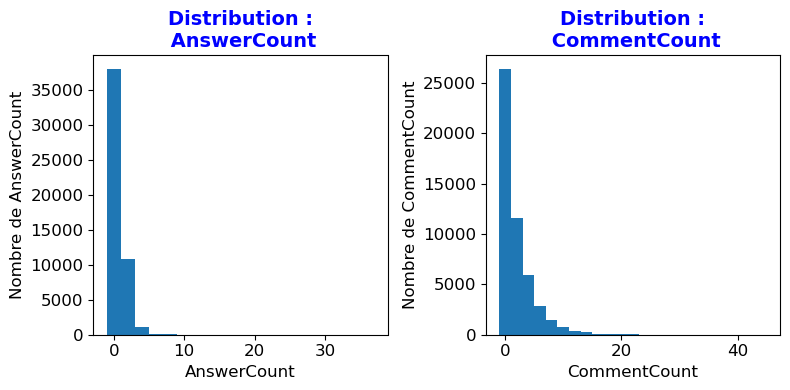

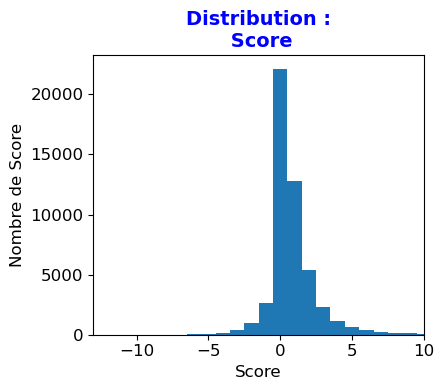

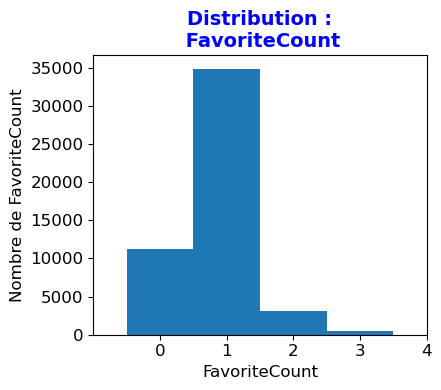

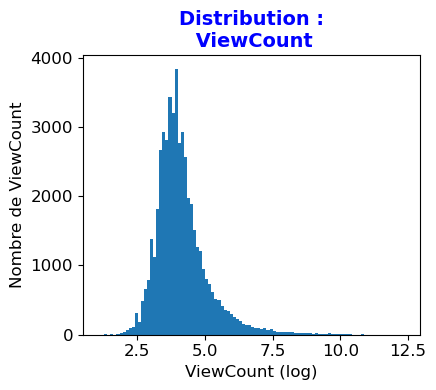

In [19]:
plot_hist(data_merge,['AnswerCount', 'CommentCount'])
plot_hist(data_merge,'Score',x_lim=(min(data_merge['Score']),data_merge['Score'].quantile(0.99)))
plot_hist(data_merge,'FavoriteCount',x_lim=(min(data_merge['FavoriteCount']-1),data_merge['FavoriteCount'].quantile(0.99)))
plot_hist(data_merge,'ViewCount',log ='yes')

<Figure size 500x400 with 0 Axes>

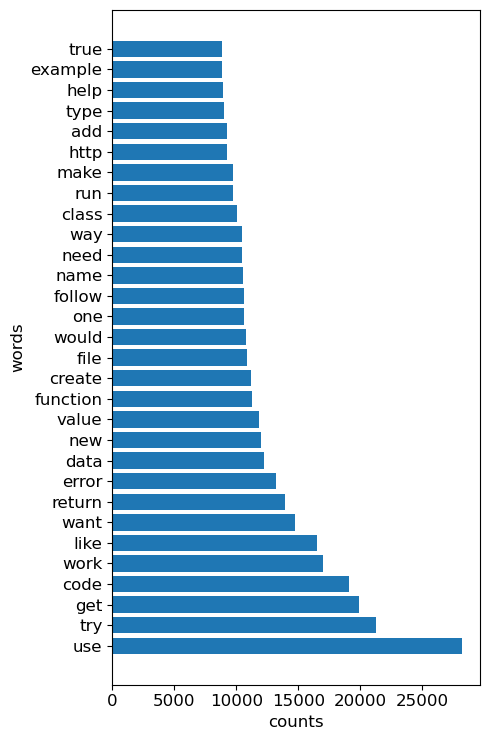

<Figure size 500x400 with 0 Axes>

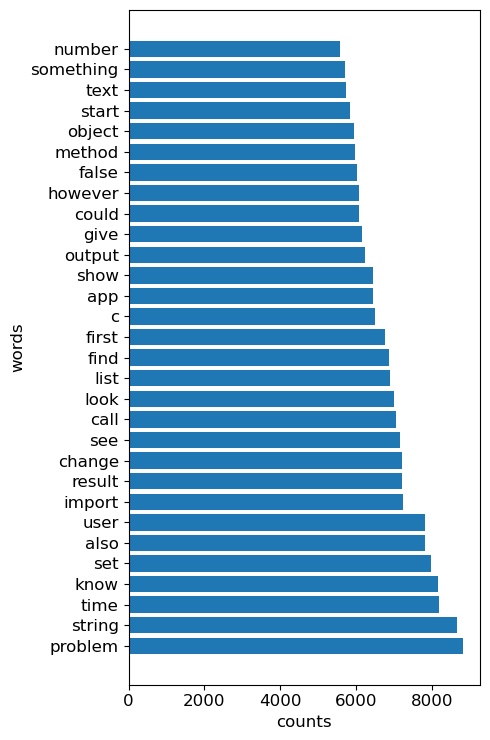

In [20]:
plot_bar(DF=None,x_cols= list(counter_word.keys())[0:30],y_cols= list(counter_word.values())[0:30],Nb_cols=1,
         inverse_xy=True, title ='', x_name= 'words',y_name = 'counts',width=5)
plot_bar(DF=None,x_cols= list(counter_word.keys())[30:60],y_cols= list(counter_word.values())[30:60],Nb_cols=1,
         inverse_xy=True, title ='', x_name= 'words',y_name = 'counts',width=5)

<Figure size 400x400 with 0 Axes>

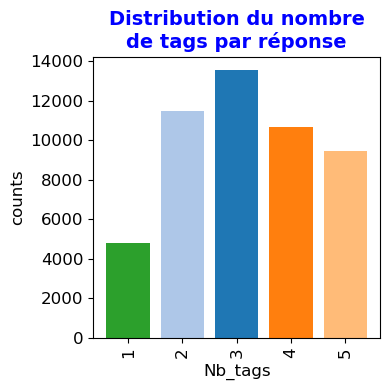

In [21]:
plot_bar(DF=DF_words_tags,x_cols= 'Nb_Tags',Nb_cols=1, title ='Distribution du nombre\nde tags par réponse', x_name= 'Nb_tags',y_name = 'counts')       

<Figure size 400x400 with 0 Axes>

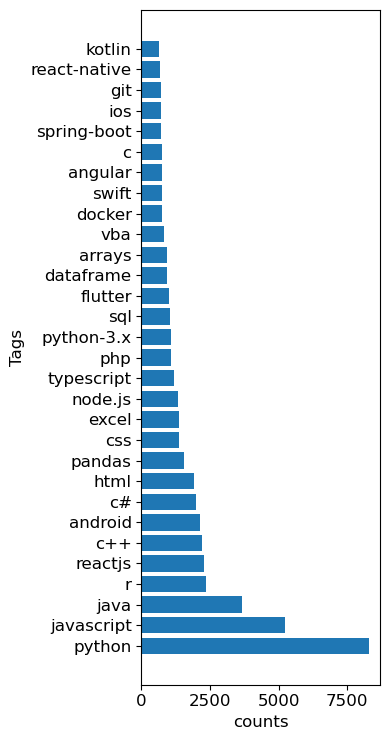

In [22]:
plot_bar(DF=None,x_cols= list(counter_tags.keys())[0:30],y_cols= list(counter_tags.values())[0:30],Nb_cols=1,
         inverse_xy=True, title ='', x_name= 'Tags',y_name = 'counts',width=4)

## <a STYLE="color:black" id="4.2">4.2 Analyse multivariée</a> 

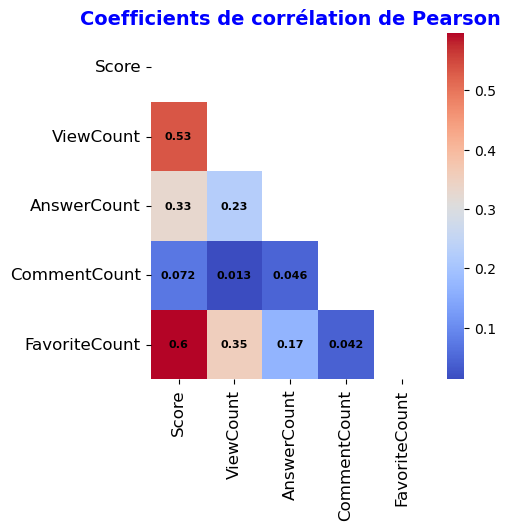

In [23]:
mat_cor(data_merge)